## Overview of GenPic on GitHub (GPGH)

GenPic ist eine Sammlung von IPython Notebooks zur Generierung und Verwaltung von Bildern im SVG Format.

1. **GPGH01-Show-Palettes** stellt die Farbpaletten aus der Datei **color-palettes.data** da.

2. **GPGH02-Picture-Generator** generiert parametergesteuert Bilder und speichert sie als *svgz* File.

2. **GPGH03-Images-to-HTML** gibt Bilder aus der Datenbank im Filesystem aus und generiert  HTML basierte Galerien zur Ansicht der Bilder im Browser. 

2. **GPGH04-Manipulate-Images** erzeugt aus manipulierten Bildern neue Bilder.

## Picture Generator

GenPic nutzt verbreitete Standardkomponenten und Python Module.

+ Daten werden in Dateien gespeichert
    + Parameter und Farbpaletten werden in **Json** gespeichert.
    + Die Bilddaten werden in **SVGZ** gespeichert. 

+ Templates werden mit **Jinja2** erstellt.

+ Die XML Bearbeitung basiert auf **lxml**.

+ **Numpy** wird zur Array und List Generierung genutzt

### Import Modules and Constants

In [6]:
# import standard moduls
import numpy as np
import random
import jinja2
import json
from lxml import etree
from math import *

from datetime import datetime
import gzip
from itertools import product
from math import sin, cos

In [82]:
##########################################################
#-------------------------- CONSTANTS -------------------#
##########################################################
# supported figures
FIGURES = ('rect', 'circle', 'polygon', 'line')

#  attributes about the picture
#!!! PICTURE_ATTRIBS = ('nr_of_figures', 'pic_struct', 'figure')
#!!! KEINE GRID RANDOM CIRCLE UND SPIRAL STRUKTUREN IMPLEMNTIERT

# attributes which position the SVG elements 
LINE_ATTRIBS =  ('x1', 'x2', 'y1', 'y2')
FIGURE_ATTRIBS = ('x', 'y', 'height', 'width')

# supported SVG 'style' attributes
SVG_ATTRIBS = ('fill', 'opacity', 'stroke',
               'stroke-opacity', 'stroke-width', 'stroke-linecap')

# define the standard input for the pictures SVG template size, background ...
PIC_ATTRIBS = {'svg_width':'21in', 'svg_height':'21in',
        'w_points':'100', 'h_points':'100',
        'fill':'white', 'opacity':'1.',
        'stroke':'goldenrod',
        'stroke_opacity':'.7', 'stroke_width':'.5'}

jinja2_template ="""<?xml version="1.0" standalone="no"?>
<svg xmlns="http://www.w3.org/2000/svg" xmlns:xlink="http://www.w3.org/1999/xlink/" 
    width="{{svg_width}}" height="{{svg_height}}" 
viewBox="0 0 {{w_points}} {{h_points}}" version="1.2">

  <desc>Picture by J. Wendt</desc>
  <!-- START Generator PARAMETERS in Json -->
  <desc>{{gen_params}}</desc>
  <!-- END Generator PARAMETERS in Json -->
  
  <!-- Show outline of canvas using 'rect' element -->
  <rect id="bg-00" x="0" y="0" width="{{w_points}}" height="{{h_points}}" fill="{{fill}}" 
    opacity="{{opacity}}" 
  stroke="{{stroke}}" stroke-opacity="{{stroke_opacity}}" stroke-width="{{stroke_width}}"/>

</svg>
"""

### Funtions

#### Basic Data And File Handling

In [86]:
#---------------------------------------------------------------------#
def timestamp():
    return datetime.now().strftime('%Y%m%d-%H%M-%S%f')
def create_output_directory(root = '', form = 'triangle'):
    directory_name = root + form + '-' + timestamp()  
    os.mkdir(directory_name)
    return directory_name
#--------------------------content -----------------------------------#
def tofile(fname, content):
    """write content to file fname """
    f = open(fname, 'wt')
    f.write(content)
    f.close()

def fromfile(fname):
    file = open (fname,'rt')
    content = file.read()
    file.close()
    return content
#---------------------------json functions----------------------------#
def save_json(fname, params):
    f = open(fname, 'w')
    json.dump(params, f, sort_keys=True, indent=2)
    f.close()

def load_json(fname):
    f = open(fname, 'r')
    result = json.load(f)
    f.close()
    return result
#---------------------------gzip functions----------------------------#
def gzip_file(fname):
    #gzip eine datei und hänge ein z an das ende
    with open(fname , 'rb') as f_in:
        with gzip.open(fname + 'z', 'wb') as f_out:
            f_out.writelines(f_in)

def unzip_file(fname):
    with open(fname , 'rb') as f:
        content = f.read()
    return gzip.decompress(content)

def gzip_content2file(fname, content):
    with gzip.open(fname, 'wb') as f:
        f.write(content)

def zip_data(string):
    return gzip.compress(bytes(string, 'utf-8'))

def unzip(data):
    return  gzip.decompress(data).decode("utf-8")

#### Geometric and coordination functions

In [9]:
#---------------------------Geometric functions-------------------------#
def create_triangle(x1,y1, l):
    """Create an isosceles triangle"""
    x2 = x1 + l
    y2 = y1 
    x3 = x1 + l/2.
    y3 = y1 + l * sin(pi/3)
    sx = x1 + l/2.
    sy = y1 + l * sin(pi/3) / 2.
    return (x1, y1, x2, y2, x3, y3, sx, sy)

#-----------------------coordinate functions------------------------------#
def new_0_coord(pos, new_0 =(40., 55.)):
    """Transform a point to a cartesian coordinate system with new_0 as zero point"""
    return [new_0[i] + pos[i] for i in [0, 1]] 

def polar2cartesian(r, theta):
    x = r * cos(theta)
    y = r * sin(theta)
    return (x, y)

def round_coord_2(p):
    return ( round(p[0], 2), round(p[1], 2) )

#-----------------------structurial functions------------------------------#
def spiral_points(rotations, length, nr_of_points):
    def spiral_radius_list(length,steps):
        """return al list of the radius for a spiral"""
        dr = float(length) / steps
        return [dr * i for i in range(steps)]

    def spiral_angle_list(rotations, steps):
        """return al list of the  angles for a spiral"""
        return [((rotations*2*pi)/steps) * i for i in range(steps)]

    return list(map(polar2cartesian, spiral_radius_list(length, nr_of_points),
            spiral_angle_list(rotations, nr_of_points)))

def circles(nr_of_cir, min_r, max_r, nr_of_points):
    def circle_points(r, nr_of_points):
        return  list(map(polar2cartesian, nr_of_points * [r],
            [((2* pi) / nr_of_points) * i for i in range(nr_of_points)]))

    dr = (max_r - min_r) / float(nr_of_cir)
    points =[]
    for s in range(nr_of_cir):
        points += circle_points( min_r + s * dr, nr_of_points)
    return points
#---------------------------------------------------------------------#
def create_grid(y_steps, x_steps, y_start=0.0, y_end=100.0, x_start=0.0, x_end=100.0):
    """Create a grid to tile a picture with rectangles
    Input:
    x_steps: Number of tiles in the row
    y_steps: Number of tiles in the columns
    ?_start, ?_end: Optinal start and end points for tiling
    Output:
    l: the tiling grid wit upper left tiling start points
    width, height: the width and height of one tile """

    x = np.linspace(x_start, x_end, x_steps +1)
    y = np.linspace(y_start, y_end, y_steps + 1)
    l = [(round(e[0], 3), round(e[1], 3)) for e in  product(x[:-1], y[:-1])]
    width = (x_end - x_start) / x_steps
    height = (y_end - y_start) / y_steps
    return l, width, height

#### Special Functions

In [13]:
#-------------------------- FUNCTIONS -------------------#
# functions to create attributte values are callable by dict keys 
def fifo_func(values):
    return values.pop(0)

def svg_rotate(x, y, w, h,  values=('rc', ((0,90), ))):
        r = RM_FUNCTION[values[0]](*values[1])
        xc = x + 0.5 * w
        yc = y + 0.5 * h
        return 'rotate(' + ', '.join((str(r), str(xc), str(yc))) + ')'

# functions are callable by dict keys
RM_FUNCTION = {'ri': random.randint,
               'rc': random.choice,
               'ro': svg_rotate,
               'ar': fifo_func}

def get_palette(palette_id):
    palettes =  load_json('color-palettes.data',)
    return palettes[str(palette_id)]

### Objects

In [83]:

class Figure(object):

    def __init__(self, figure, params):
        self.figure = figure
        if self.figure == 'line':
            self.mandatory_attribs = LINE_ATTRIBS
        else:
            self.mandatory_attribs = FIGURE_ATTRIBS
        self.params = params
        self.attribs = {}

        self.checked = self.set_and_check_mandatory_attributes()
        self.set_attributes()

    def set_and_check_mandatory_attributes(self):
        if not self.figure in FIGURES:
            return False
        ok = True
        for attr in self.mandatory_attribs:
            if not attr in self.params:
                ok = False
                print (self.figure, attr, ':\tnot defined.')
                break
        return ok

    def set_attributes(self):
        for attr in self.params:
            if (attr in self.mandatory_attribs) or (attr in SVG_ATTRIBS):
                v = self.params[attr]
                self.attribs[attr] = RM_FUNCTION[v[0]](*v[1])
        if 'transform' in self.params and not self.figure == 'line':
            self.attribs['transform'] = svg_rotate(\
                *[self.attribs[k] for k in ('x','y','width','height')],
                values = self.params['transform'])

    def attribs_to_string(self):
        return {k: str(v) for k, v in self.attribs.items()}


class SVGPicture(object):

    def __init__(self, params, pic_attribs=PIC_ATTRIBS):
        self.pic_attribs = pic_attribs
        self.params = params
        self.create_picture()

    def create_picture(self):
        self.set_svg_root()
        #for fig in self.params["figures"]:
        for i in range(self.params["nr_of_figures"]):
            f = self.params['figures']
            figure = RM_FUNCTION[f[0]](*f[1])
            self.root.append(etree.Element(figure,
                    attrib= Figure(figure, self.params).attribs_to_string()))
        self.fit_svg_circles()
        self.fit_svg_polygons()

    def add_figures(self, figures):
        for fig in figures:
            self.root.append(etree.Element(fig,
                    attrib= Figure(fig, self.params).attributes_to_str()))
        self.fit_svg_circles()
        self.fit_svg_polygons()
        self.new_image = True

    def set_svg_root(self, template_id=4):
        #load the SVG-template to jinja2
    
        template = jinja2.Template(jinja2_template)
        self.pic_attribs['gen_params'] = self.params_to_json()
        svg_base = template.render(self.pic_attribs)
        # Create a basic SVG/XML root
        self.root = etree.fromstring(svg_base)

    def fit_svg_circles(self):
        elem_circles = self.root.findall('circle')
        for e in elem_circles:
            e.attrib['r'] = "{:0.2f}".format(max(float(e.attrib['height']),
                                                 float(e.attrib['width'])) / 2)
            e.attrib['cx'] = "{:0.2f}".format(float(e.attrib['x']) + float(e.attrib['r']))
            e.attrib['cy'] = "{:0.2f}".format(float(e.attrib['y']) + float(e.attrib['r']))
            etree.strip_attributes(e, 'x', 'y', 'width', 'height', 'transform')

    def fit_svg_polygons(self):
        elem_polygons = self.root.findall('polygon')
        for e in elem_polygons:
            e.attrib['width'] = e.attrib['height']
            t = create_triangle(float(e.attrib['x']), float(e.attrib['y']) ,
                                max(float(e.attrib['height']), float(e.attrib['width'])))
            e.attrib['points'] = "{:0.2f},{:0.2f} {:0.2f},{:0.2f} {:0.2f},{:0.2f}".\
            format(*t[:-2])
            etree.strip_attributes(e, 'x', 'y', 'width', 'height')

    def add_id_to_svg_elems(self):
        def idplus1_func(a):
            return a + 1
        tags = ('rect', 'cirlce', 'polygon', 'line')
        c = [e for e in self.root.getchildren() if e.tag in tags]
        self.add_tag_to_elements('id', id1_func, c)

    def add_figures(self, figures):
        for fig in figures:
            self.root.append(etree.Element(fig,
                    attrib= Figure(fig, self.params).attributes_to_str()))
        self.fit_svg_circles()
        self.fit_svg_polygons()

    def add_tag_to_svg_elems(self, tag, valfunc, elements):
        for i, e in enumerate(elements):
            e.attrib[tag] = str(valfunc(i))

    def copyright_to_xml(self):
        # append a copyriht information to the SVG output. Set x,y position etc.. 
        copyright = etree.SubElement(self.root, "text")
        copyright.text = "© d-j-w, Hamburg 2016 - " + timestamp()
        copyright.attrib['x'] = "1"
        copyright.attrib['y'] = "99"
        copyright.attrib['fill'] = "silver"
        copyright.attrib['style'] = "font-size:0.5mm"
            

    def xml_to_string(self):
        # convert the SVG/XML root to a string  
        return '<?xml version="1.0" standalone="no"?>\n' + \
            etree.tostring(self.root).decode('utf-8').replace('><', '>\n<')


    def params_to_json(self):
        # This has to be done  if the params changed BEFORE THE IMAGE IS STORED
        const_attrs = {}
        const_attrs['params'] = {k:v for k,v in self.params.items() if
                               (not type(v) == tuple) or not v[0] == 'ar' }

        return json.dumps(const_attrs, separators=(',', ':'))

    def to_file(self):
        #store image into a file
        f = open('pic-' + timestamp() + '.svgz', 'wb')
        f.write(zip_data(self.xml_to_string()))
        f.close()
        print(timestamp())

###  Line Construction

In [17]:
from random import randint, choice

def get_random_border_point(start_x=0, end_x=100, start_y=0, end_y=100):
    """return a Point which lays on the border of the picture"""
    fixed_side = choice(('x', 'y'))
    if fixed_side == 'x':
        fixed_num = choice((start_x, end_x))
        var = randint(start_y, end_y)
        return(fixed_num, var)
    elif fixed_side == 'y':
        fixed_num = choice((start_y, end_y))
        var = randint(start_x, end_x)
        return(var, fixed_num)

In [18]:
nr_of_origins = 30
nr_of_lines = 100

origins_x_area = (0, 100)
origins_y_area = (100, 100)

target_x_area = (0, 100)
target_y_area = (0, 0)

# Define starting points for the lines
origins =[]
targets =[]
for i in range(nr_of_origins):
    origins.append((randint(origins_x_area[0], origins_x_area[1]),
                    randint(origins_y_area[0], origins_y_area[1])))
for i in range(nr_of_lines):
    targets.append((randint(target_x_area[0], target_x_area[1]),
                    randint(target_y_area[0], target_y_area[1])))

# Define lines
lines =[]
for i in range(nr_of_lines):
    p1 = choice(origins)
    p2 = choice(targets)
    lines.append((p1[0], p1[1], p2[0], p2[1]))

## Produce Pictures

In [20]:
import copy
from IPython.display import HTML, SVG

In [64]:
# Define basic picture attributtes for the pictures SVG template  like size, background ...
pic_attribs = {'svg_width':'21in', 'svg_height':'21in',
        'w_points':'100', 'h_points':'100',
        'fill':'red', 
        'opacity':'1.',
        'stroke':'goldenrod',
        'stroke_opacity':'.3', 
        'stroke_width':'35'}

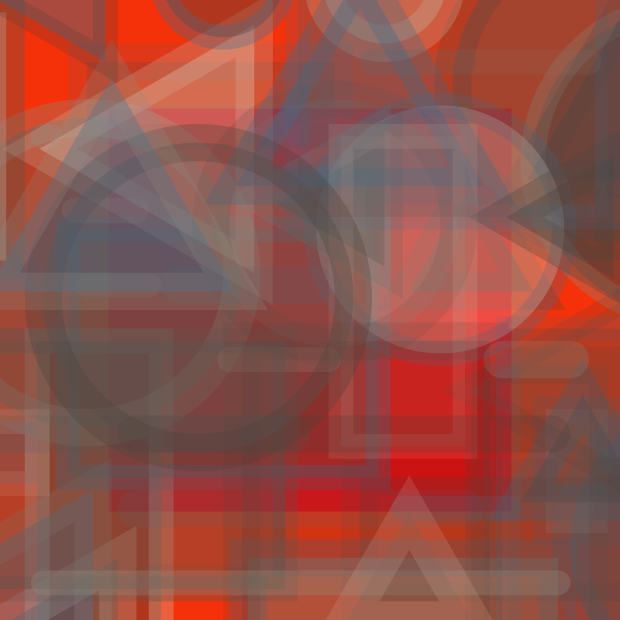

In [84]:
color_id = 714
nr_of_figures = 64
# set the colors
palette = get_palette(color_id)
params ={}
params['structure'] = 'RANDOM'
params['colorid'] = color_id
params['palette'] = palette
params['nr_of_figures'] = nr_of_figures
figs_to_choice = ( 'rect' , 'polygon', 'circle', 'line',) #'rect', 'circle', 'polygon',
#params['figures'] = [random.choice(figs_to_choice) for i in range(nr_of_figures)]
params['figures'] = ('rc', [figs_to_choice, ]) 

# params for creation of circles rects and polygons(triangles) 
params['x'] = ('ri', [-20, 120])
params['y'] = ('ri', [-20, 120])
params['height'] = ('rc', ([40, 20,   ], ))
params['width'] = ('rc', ([50, 10, ], ))

# params for line creation
params['x1'] = ('ar', ([l[0] for l in lines], ))
#params['y1'] = ('ar', ([l[1] for l in lines], ))
params['x2'] = ('ar', ([l[2] for l in lines], ))  #('ri', [0, 100])
#params['y2'] = ('ar', ([l[3] for l in lines], ))
y1_list = list(range(10, 100, 12)) * int((nr_of_figures / 3))
params['y1'] = ('ar', (y1_list, ))
y2_list = copy.deepcopy(y1_list)
params['y2'] = ('ar', (y2_list, ))

# params for svg style 
params['fill'] = ('rc', [palette[:],] )
params['opacity'] = ('rc', [( .2, .4), ]) 
params['stroke'] = ('rc', [palette[:],] )
params['stroke-linecap'] = ('rc', (["round",], ))
params['stroke-opacity'] = ('rc', [( .8, .6), ])
params['stroke-width'] = ('rc', [(6, 4  ), ])
params['transform'] = ('rc', [[ 90, 180  ], ])

svg = SVGPicture(params, pic_attribs=pic_attribs) 
SVG(svg.xml_to_string().replace('21in', '620px'))

In [85]:
print(svg.xml_to_string())

<?xml version="1.0" standalone="no"?>
<svg xmlns="http://www.w3.org/2000/svg" xmlns:xlink="http://www.w3.org/1999/xlink/" width="21in" height="21in" viewBox="0 0 100 100" version="1.2">

  <desc>Picture by J. Wendt</desc>
  <!-- Generator PARAMETERS in Json -->
  <desc>{"params":{"transform":["rc",[[90,180]]],"colorid":714,"structure":"RANDOM","height":["rc",[[40,20]]],"palette":["#3E6E90","#4C423D","#DBBEAA","#5A5550","#928A7E"],"figures":["rc",[["rect","polygon","circle","line"]]],"stroke-linecap":["rc",[["round"]]],"fill":["rc",[["#3E6E90","#4C423D","#DBBEAA","#5A5550","#928A7E"]]],"nr_of_figures":64,"stroke":["rc",[["#3E6E90","#4C423D","#DBBEAA","#5A5550","#928A7E"]]],"y":["ri",[-20,120]],"x":["ri",[-20,120]],"stroke-width":["rc",[[6,4]]],"width":["rc",[[50,10]]],"opacity":["rc",[[0.2,0.4]]],"stroke-opacity":["rc",[[0.8,0.6]]]}}</desc>
  <!-- Show outline of canvas using 'rect' element -->
  <rect id="bg-00" x="0" y="0" width="100" height="100" fill="red" opacity="1." stroke="golde

In [76]:
svg.params_to_string()

'{"params":{"transform":["rc",[[90,180]]],"colorid":714,"structure":"RANDOM","height":["rc",[[40,20]]],"palette":["#3E6E90","#4C423D","#DBBEAA","#5A5550","#928A7E"],"figures":["rc",[["rect","polygon","circle","line"]]],"stroke-linecap":["rc",[["round"]]],"fill":["rc",[["#3E6E90","#4C423D","#DBBEAA","#5A5550","#928A7E"]]],"nr_of_figures":64,"stroke":["rc",[["#3E6E90","#4C423D","#DBBEAA","#5A5550","#928A7E"]]],"y":["ri",[-20,120]],"x":["ri",[-20,120]],"stroke-width":["rc",[[6,4]]],"width":["rc",[[50,10]]],"opacity":["rc",[[0.2,0.4]]],"stroke-opacity":["rc",[[0.8,0.6]]]}}'

## Save Picture To File

In [35]:
svg.to_file()

20160725-1726-56173173


In [68]:
svg.params_to_string()

'{"params":{"transform":["rc",[[90,180]]],"colorid":714,"structure":"RANDOM","height":["rc",[[40,20]]],"palette":["#3E6E90","#4C423D","#DBBEAA","#5A5550","#928A7E"],"figures":["rc",[["rect","polygon","circle","line"]]],"stroke-linecap":["rc",[["round"]]],"fill":["rc",[["#3E6E90","#4C423D","#DBBEAA","#5A5550","#928A7E"]]],"nr_of_figures":64,"stroke":["rc",[["#3E6E90","#4C423D","#DBBEAA","#5A5550","#928A7E"]]],"y":["ri",[-20,120]],"x":["ri",[-20,120]],"stroke-width":["rc",[[6,4]]],"width":["rc",[[50,10]]],"opacity":["rc",[[0.2,0.4]]],"stroke-opacity":["rc",[[0.8,0.6]]]}}'